# Go through midi and get transition statistics

In [1]:
import os
import json

from algorithm.transduction_model import chord_tuple_list_to_string, chord_string_to_list, get_note_transition_dict

In [2]:
midi_dir = os.path.join("data", "midi", "2004")
note_transition_dict_save_path = os.path.join("data", "note_transition_dict_2004.json")

if os.path.exists(note_transition_dict_save_path):
    with open(note_transition_dict_save_path, 'r') as fin:
        note_transition_dict = json.load(fin)
else:
    note_transition_dict = get_note_transition_dict(midi_dir)
    with open(note_transition_dict_save_path, 'w') as fout:
        json.dump(note_transition_dict, fout)

In [3]:
print(len(note_transition_dict))
for key in note_transition_dict:
    this_pitches = key
    print(this_pitches, chord_string_to_list(this_pitches))
    for subkey in note_transition_dict[key]:
        print(key, "->", subkey, ":", note_transition_dict[key][subkey])
    break
    

83038
50 [50]
50 -> 34,50 : 68
50 -> 46,51 : 10
50 -> 43,50 : 54
50 -> 29,50 : 27
50 -> 31,46,50 : 1
50 -> 34 : 20
50 -> 31,51 : 3
50 -> 50,51 : 63
50 -> 31,48,50 : 3
50 -> 46,50 : 98
50 -> 48 : 206
50 -> 53 : 178
50 -> 24 : 10
50 -> 26 : 19
50 -> 17,51 : 4
50 -> 41,50 : 62
50 -> 39,50 : 21
50 -> 55 : 66
50 -> 52 : 124
50 -> 50,53 : 44
50 -> 24,48 : 3
50 -> 26,48 : 4
50 -> 38,50 : 107
50 -> 36 : 28
50 -> 24,52 : 2
50 -> 29,48 : 7
50 -> 39,48 : 9
50 -> 38,52 : 5
50 -> 43,51 : 11
50 -> 34,53 : 4
50 -> 31,58 : 6
50 -> 27,34,55 : 1
50 -> 50,60 : 9
50 -> 27,34,50 : 1
50 -> 29 : 16
50 -> 51 : 188
50 -> 29,51 : 7
50 -> 27,46,55 : 3
50 -> 41,45,48 : 1
50 -> 26,46 : 7
50 -> 33,50 : 32
50 -> 38,50,60 : 2
50 -> 35,50 : 24
50 -> 38,59 : 3
50 -> 34,51 : 6
50 -> 26,50 : 22
50 -> 58 : 46
50 -> 45,48 : 5
50 -> 29,46,50 : 4
50 -> 46 : 133
50 -> 45,53,60 : 7
50 -> 41 : 41
50 -> 36,52 : 5
50 -> 46,58 : 2
50 -> 41,50,53,63 : 1
50 -> 31,50 : 24
50 -> 31,50,58 : 4
50 -> 43,50,58 : 2
50 -> 27,55 : 4
50 -> 31

# Train the transmit-probability-estimation neural net

## load Fourier-frame-transcribed results 

In [ ]:
import os

import torch
from torch.utils.data import DataLoader, BatchSampler, RandomSampler, random_split, ConcatDataset
import matplotlib.pyplot as plt

from data.torch_dataset import TransmitModelDataset, collate_fn_transduction
from model.transduction_net import TransductionFC
from algorithm.train_transduction import train_transduction

# important: choose the data source in training the transduction model

# transcription_json_dir = os.path.join("data", "acoustic_model_out", "fourier_frame_acoustic_model_out_trained", "2004")
# transcription_with_alg_seg_json_dir = os.path.join("data", "acoustic_model_out", "fourier_frame_acoustic_model_out_trained_alg_seg", "2004")
# transcription_json_dir = os.path.join("data", "acoustic_model_out", "unrolled_mse_model_out", "2004")
# transcription_json_dir = os.path.join("data", "acoustic_model_out", "fourier_frame_acoustic_model_out_trained", "2004")
transcription_json_dir = os.path.join("data", "acoustic_model_out", "fourier_frame_acoustic_model_out_nuv", "2004")
transcription_with_alg_seg_json_dir = os.path.join("data", "acoustic_model_out", "fourier_frame_acoustic_model_out_nuv_alg_seg", "2004")

transmit_model_dataset = TransmitModelDataset(transcription_json_dir, data_len = 64, hop_len = 4)
transmit_model_dataset_alg_seg = TransmitModelDataset(transcription_json_dir, data_len = 64, hop_len = 4)

transmit_model_dataset = ConcatDataset([transmit_model_dataset, transmit_model_dataset_alg_seg])

print(len(transmit_model_dataset))

plt.plot(transmit_model_dataset[999]["gt_velocity_rolls"][0])
plt.plot(transmit_model_dataset[999]["est_velocity_rolls"][0])
print(transmit_model_dataset[999]["gt_velocity_rolls"].shape)

## Train the transmit probability estimation neural net

In [ ]:
def split_dataset(dataset, train_val_test_split = [0.8,0.1,0.1]):
    train_val_test_split[0] = int(train_val_test_split[0]*len(dataset))
    train_val_test_split[1] = int(train_val_test_split[1]*len(dataset))
    train_val_test_split[2] = int(len(dataset) - train_val_test_split[0] - train_val_test_split[1])
    train_set, val_set, test_set = random_split(
        dataset, train_val_test_split
    )
    return train_set, val_set, test_set

def get_data_loaders_from_dataset(train_set, val_set, test_set, batch_size = 16):
    train_sampler = BatchSampler(RandomSampler(train_set), batch_size=batch_size, drop_last=True)
    val_sampler = BatchSampler(RandomSampler(val_set), batch_size=1, drop_last=True)

    train_loader = DataLoader(dataset=train_set, 
        batch_sampler=train_sampler, collate_fn=collate_fn_transduction, pin_memory=True
    )
    val_loader = DataLoader(dataset=val_set, 
        batch_sampler=val_sampler, collate_fn=collate_fn_transduction, pin_memory=True
    )
    test_loader = DataLoader(dataset=test_set, collate_fn=collate_fn_transduction, pin_memory=True
    )
    return train_loader, val_loader, test_loader

train_set, val_set, test_set = split_dataset(transmit_model_dataset, train_val_test_split = [0.8,0.1,0.1])
train_loader, val_loader, test_loader = get_data_loaders_from_dataset(train_set, val_set, test_set, batch_size = 16)

training using cuda
[    0] loss: 0.01381; validate P,R,F1: 0.0314,0.5351,0.0594
[  500] loss: 1.64524; validate P,R,F1: 0.5000,0.0010,0.0020
[ 1000] loss: 0.89898; validate P,R,F1: 0.8645,0.1373,0.2370
[ 1500] loss: 0.73306; validate P,R,F1: 0.9263,0.2943,0.4467
[ 2000] loss: 0.66490; validate P,R,F1: 0.9142,0.3942,0.5509
[ 2500] loss: 0.61448; validate P,R,F1: 0.9065,0.4158,0.5701
[ 3000] loss: 0.59253; validate P,R,F1: 0.9199,0.4826,0.6331
[ 3500] loss: 0.56655; validate P,R,F1: 0.9134,0.4421,0.5958
[ 4000] loss: 0.55159; validate P,R,F1: 0.9198,0.5233,0.6671
[ 4500] loss: 0.53754; validate P,R,F1: 0.9085,0.5282,0.6680
[ 5000] loss: 0.52842; validate P,R,F1: 0.9084,0.4223,0.5765
[ 5500] loss: 0.52145; validate P,R,F1: 0.9235,0.5048,0.6528
[ 6000] loss: 0.51085; validate P,R,F1: 0.9325,0.5009,0.6517
[ 6500] loss: 0.50874; validate P,R,F1: 0.9212,0.5220,0.6664
[ 7000] loss: 0.50417; validate P,R,F1: 0.9360,0.5446,0.6886
[ 7500] loss: 0.49862; validate P,R,F1: 0.9366,0.5609,0.7016
[ 80

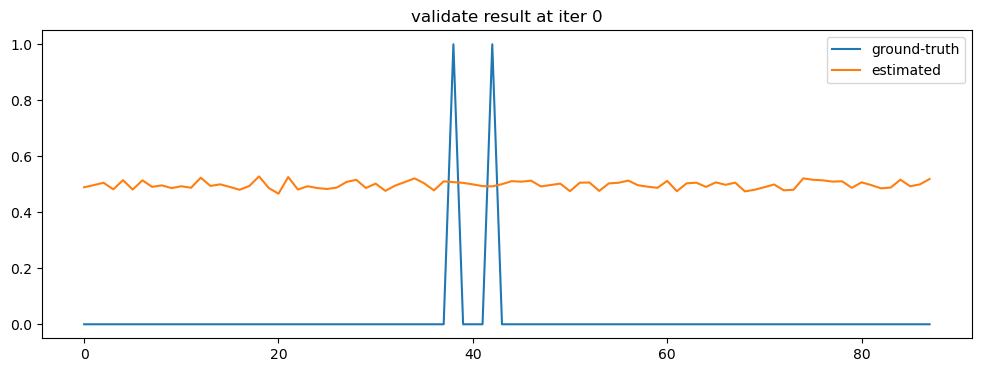

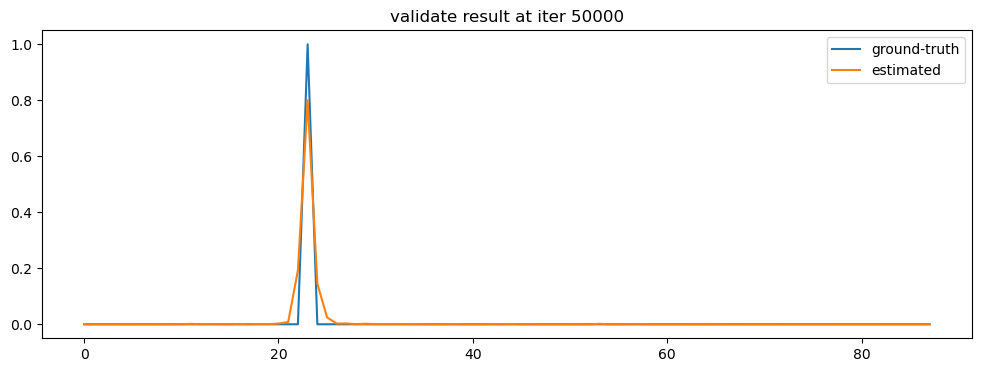

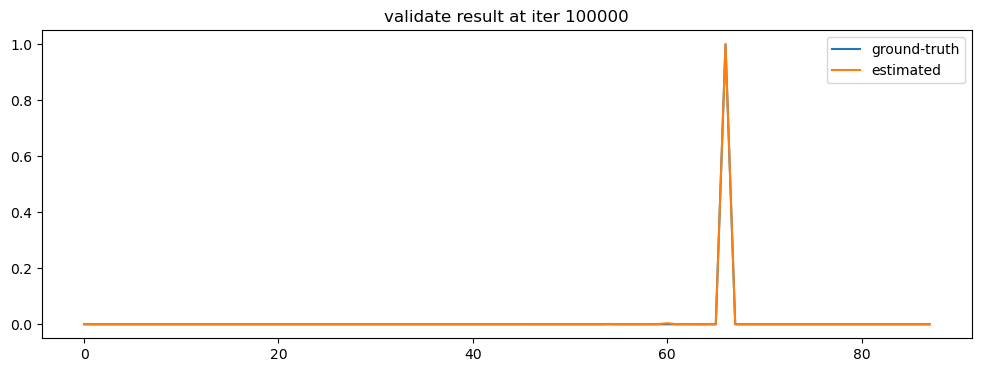

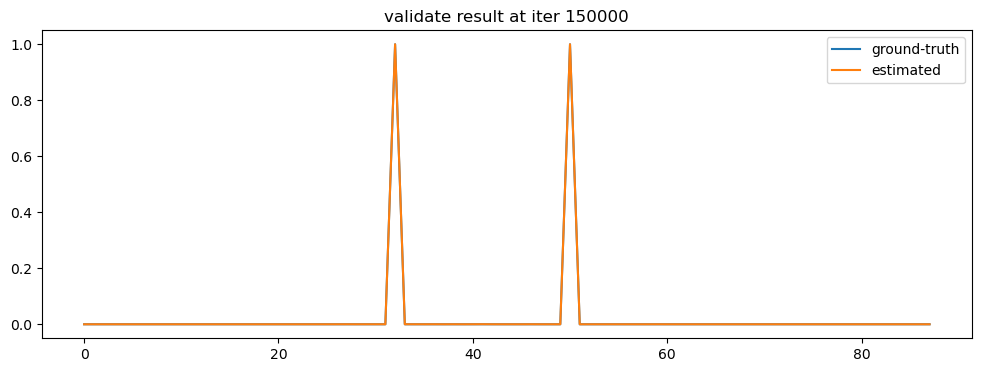

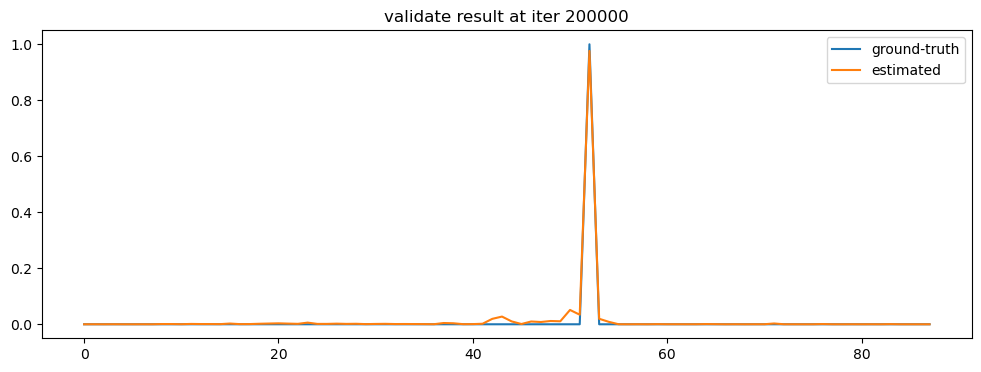

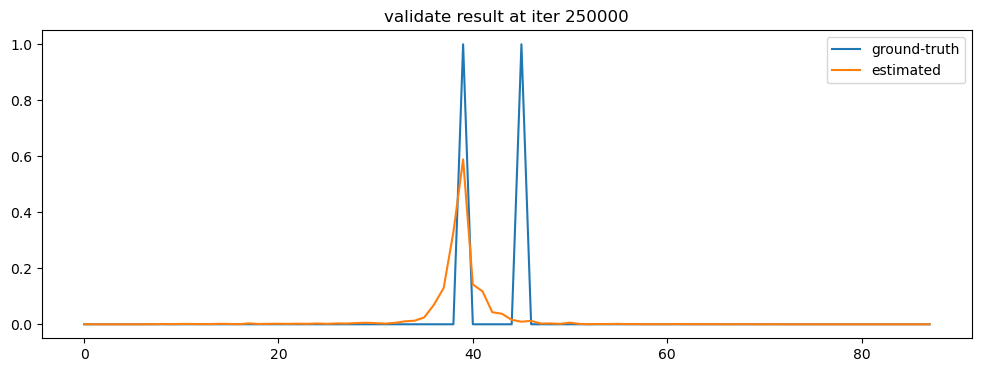

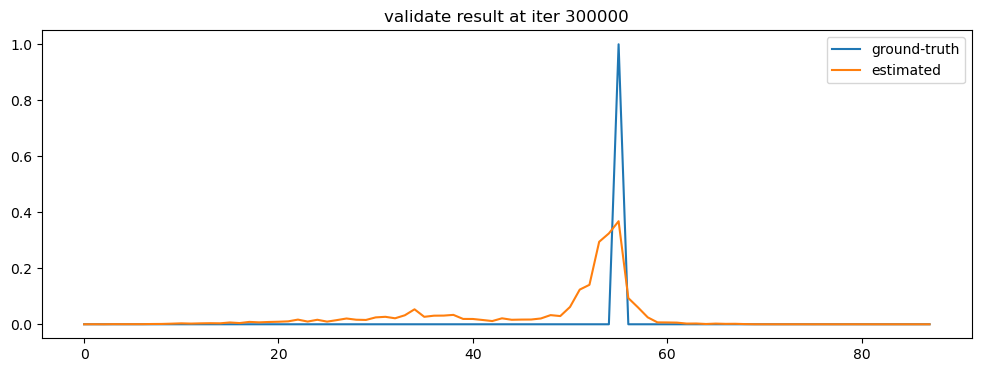

In [3]:
transduction_nn = TransductionFC()
training_config = {
    "device": "cuda",
    "checkpoint_dir": "checkpoints",
#     "checkpoint_name": "TransductionFC_0_18-01-2023-14-40-38.pth",
    "model_name": "TransductionFC",
    "learning_rate": 0.0005,
    "max_train_iter": 310000,
    "print_iter": 500,
    "save_checkpoint_iter": 10000,
    "validate_iter": 20
}

train_transduction(training_config, transduction_nn, train_loader,
    validate_loader = val_loader, save = True, plot_validate = True, plot_train = False
)

# Assemble the transition and transmit part, implement the HMM as transduction model

In [1]:
import os
import json
import numpy as np
import torch
from torch.utils.data import random_split
import matplotlib.pyplot as plt

from model.transduction_net import TransductionFC
from data.torch_dataset import TransmitModelDataset
from data.data_utils import pitch_velocity_rolls_onsets_offsets_to_piano_roll
from algorithm.transduction_model import get_candidate_pitches_and_logprobs, get_transition_prior, get_transition_posterior, chord_string_to_list
from algorithm.transduction_model import single_chord_hmm_viterbi_decoding, str_decisions_to_pitch_rolls

from utils import move_data_to_device
from hyperparameters import PITCH_NUM

# read the note-transition dictionary
midi_dir = os.path.join("data", "midi", "2004")
note_transition_dict_save_path = os.path.join("data", "note_transition_dict_2004.json")
if os.path.exists(note_transition_dict_save_path):
    with open(note_transition_dict_save_path, 'r') as fin:
        note_transition_dict = json.load(fin)
else:
    note_transition_dict = get_note_transition_dict(midi_dir)
    with open(note_transition_dict_save_path, 'w') as fout:
        json.dump(note_transition_dict, fout)
        
# create the piece dataset for HMM testing
if "test_set" not in globals():
    transcription_json_dir = os.path.join("data", "fourier_frame_acoustic_model_out", "2004")
    transmit_model_dataset = TransmitModelDataset(transcription_json_dir, data_len = 64, hop_len = 4)
    train_val_test_split = [0.8,0.1,0.1]
    train_val_test_split[0] = int(train_val_test_split[0]*len(transmit_model_dataset))
    train_val_test_split[1] = int(train_val_test_split[1]*len(transmit_model_dataset))
    train_val_test_split[2] = int(len(transmit_model_dataset) - train_val_test_split[0] - train_val_test_split[1])
    train_set, val_set, test_set = random_split(
        transmit_model_dataset, train_val_test_split
    )

# load the transmit-probability-prediction model checkpoint
if "transduction_nn" not in globals():
    transduction_nn = TransductionFC()
    checkpoint_dir = "checkpoints"
    checkpoint_name = "TransductionFC_199999_03-12-2022-17-50-34.pth"
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
    if os.path.exists(checkpoint_path):
        i_iter = int(checkpoint_name.split("_")[1])+1
        transduction_nn.load_state_dict(torch.load(checkpoint_path))
        print("loaded checkpoint ", checkpoint_name)
    else:
        print("checkpoint not found... Please train the transmit probability estimation NN first.")

loaded checkpoint  TransductionFC_199999_03-12-2022-17-50-34.pth


In [2]:
get_candidate_pitches_and_logprobs(np.array([0,0.9,0.3,0.1,0.8,0]))

{'1': -3.139259621703743,
 '2': -7.530020627209253,
 '3': -9.476546257328799,
 '4': -4.30844378114993,
 '1,2': -4.361377309396725,
 '1,3': -6.307902939516271,
 '1,4': -1.139800463337401,
 '2,3': -10.698663945021782,
 '2,4': -5.530561468842912,
 '3,4': -7.477087098962458,
 '1,2,3': -7.530020627209253,
 '1,2,4': -2.3619181510303835,
 '1,3,4': -4.308443781149929,
 '2,3,4': -8.69920478665544,
 '1,2,3,4': -5.530561468842912}

In [3]:
get_transition_prior([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "4,11")

(array([0.35 , 0.2  , 0.35 , 0.35 , 0.7  , 0.35 , 0.4  , 0.4  , 0.4  ,
        0.4  , 0.35 , 0.7  , 0.35 , 0.35 , 0.2  , 0.35 , 0.4  , 0.15 ,
        0.2  , 0.15 , 0.15 , 0.001, 0.15 , 0.2  , 0.001]),
 0.00025907518226757435)

In [4]:
for key in note_transition_dict:
    prev_pitches = np.array(chord_string_to_list(key))
    prev_pitch_roll = np.zeros(PITCH_NUM)
    prev_pitch_roll[prev_pitches] = 1
    
    for subkey in note_transition_dict[key]:
        choice_str = subkey
        posterior = get_transition_posterior(prev_pitch_roll, choice_str, note_transition_dict, n_prior = 100)
        print(key, "->", subkey, ":", "num =", note_transition_dict[key][subkey], "; posterior =", posterior)
    break

50 -> 34,50 : num = 68 ; posterior = 0.012039759569191462
50 -> 46,51 : num = 10 ; posterior = 0.0017767515574826525
50 -> 43,50 : num = 54 ; posterior = 0.009585759771007098
50 -> 29,50 : num = 27 ; posterior = 0.0047805527703246075
50 -> 31,46,50 : num = 1 ; posterior = 0.00017707870249616614
50 -> 34 : num = 20 ; posterior = 0.003541175999786364
50 -> 31,51 : num = 3 ; posterior = 0.0005311863512213786
50 -> 50,51 : num = 63 ; posterior = 0.011179244190270554
50 -> 31,48,50 : num = 3 ; posterior = 0.0005311863512213786
50 -> 46,50 : num = 98 ; posterior = 0.01737612804296177
50 -> 48 : num = 206 ; posterior = 0.03649794107412324
50 -> 53 : num = 178 ; posterior = 0.03154043399197027
50 -> 24 : num = 10 ; posterior = 0.0017706377561603017
50 -> 26 : num = 19 ; posterior = 0.003364122175423758
50 -> 17,51 : num = 4 ; posterior = 0.0007082401755839848
50 -> 41,50 : num = 62 ; posterior = 0.010994880584900195
50 -> 39,50 : num = 21 ; posterior = 0.003735673786033339
50 -> 55 : num = 66 

In [5]:
i_data = 0
test_est_velocity_rolls = test_set[i_data]["est_velocity_rolls"]
gt_est_velocity_rolls = test_set[i_data]["gt_velocity_rolls"]

test_est_velocity_rolls =  move_data_to_device(test_est_velocity_rolls, "cpu")
test_durs =  torch.unsqueeze(move_data_to_device(transmit_model_dataset[i_data]["offsets"] - transmit_model_dataset[i_data]["onsets"], "cpu"), 1) # (T,1)
test_input = torch.cat([test_est_velocity_rolls, test_durs], dim = 1) # (T,89)
with torch.no_grad():
    test_est_pitch_prob_rolls = transduction_nn(test_input).numpy()
    test_est_pitch_prob_rolls[test_est_pitch_prob_rolls < 0.1] = 0

In [6]:
decisions = single_chord_hmm_viterbi_decoding(test_est_pitch_prob_rolls, note_transition_dict, verbose = True)
opt_pitch_rolls = str_decisions_to_pitch_rolls(decisions, num_pitches = PITCH_NUM)

-= Getting support sets and transmit probabilities =-
chord number 0 support sets: 34 ; ...; 34,46 ; total num:  3
chord number 1 support sets: 32 ; ...; 32,46 ; total num:  3
chord number 2 support sets: 29 ; ...; 29,38 ; total num:  3
chord number 3 support sets: 12,13,22 ; ...; 10,22 ; total num:  16
chord number 4 support sets: 8,9,10 ; ...; 10 ; total num:  16
...
chord number 63 support sets: 34 ; ...; 34 ; total num:  1
-= Implementing Viterbi =-
chord number 1 Viterbi temp values: [-29.684721 -29.789204 -16.608967]
chord number 2 Viterbi temp values: [-45.95216  -40.109447 -33.22944 ]
chord number 3 Viterbi temp values: [-59.22002  -59.066296 -59.050617 -58.710243 -53.101883 -56.485756
 -56.423843 -56.31274  -56.10912  -55.96771  -55.943417 -53.72567
 -53.3853   -53.276936 -53.212955 -50.618473]
chord number 4 Viterbi temp values: [-71.38529  -65.395454 -65.7739   -69.639755 -71.08359  -67.5635
 -70.33762  -67.16898  -70.199745 -64.760704 -68.77755  -64.366196
 -68.66876  -63.0

Text(0.5, 1.0, 'estimated piano roll after HMM')

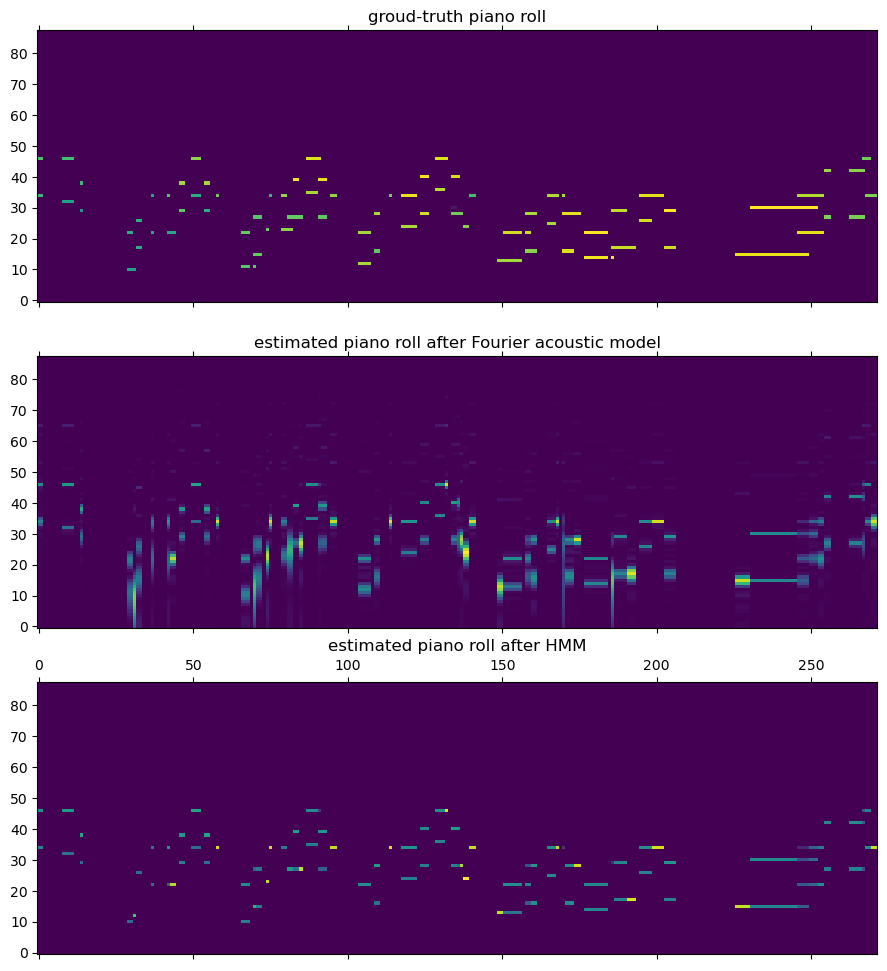

In [7]:
gt_piano_roll = pitch_velocity_rolls_onsets_offsets_to_piano_roll(
    test_set[i_data]["gt_velocity_rolls"], test_set[i_data]["gt_velocity_rolls"], test_set[i_data]["onsets"], test_set[i_data]["offsets"], relative_time = True
)
est_piano_roll_raw = pitch_velocity_rolls_onsets_offsets_to_piano_roll(
    test_set[i_data]["est_velocity_rolls"], test_set[i_data]["est_velocity_rolls"], test_set[i_data]["onsets"], test_set[i_data]["offsets"], relative_time = True
)
est_piano_roll_hmm = pitch_velocity_rolls_onsets_offsets_to_piano_roll(
    opt_pitch_rolls, test_set[i_data]["est_velocity_rolls"], test_set[i_data]["onsets"], test_set[i_data]["offsets"], relative_time = True
)

show_len = min(len(gt_piano_roll), 10000)

fig, ax = plt.subplots(3,1,figsize = (16,12), sharex = True, sharey = True)
ax[0].matshow(gt_piano_roll[:show_len:20].T, origin="lower")
ax[0].set_title("groud-truth piano roll")
ax[1].matshow(est_piano_roll_raw[:show_len:20].T, origin="lower")
ax[1].set_title("estimated piano roll after Fourier acoustic model")
ax[2].matshow(est_piano_roll_hmm[:show_len:20].T, origin="lower")
ax[2].set_title("estimated piano roll after HMM")